# Homework 5: Problems
## Due Wednesday 28 October, before class

### PHYS 440/540, Fall 2020
https://github.com/gtrichards/PHYS_440_540/


## Problems 1&2

Complete Chapters 1 and 2 in the *unsupervised learning* course in Data Camp.  The last video (and the two following code examples) in Chapter 2 are off topic, but we'll discuss those next week, so this will be a good intro.  The rest is highly relevant to this week's material.  These are worth 1000 and 900 points, respectively.  I'll be grading on the number of points earned instead of completion (as I have been), so try to avoid using the hints unless you really need them.

## Problem 3

Fill in the blanks below.  This exercise will take you though an example of everything that we did this week.  Please copy the relevant import statements (below) to the cells where they are used (so that they can be run out of order).  

If a question is calling for a word-based answer, I'm not looking for more than ~1 sentence.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

Setup up the data set.  We will do both density estimation and clustering on it.

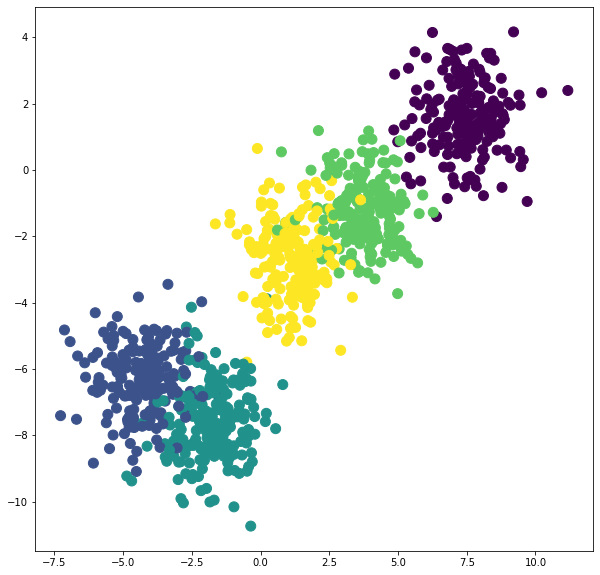

In [211]:
from sklearn.datasets import make_blobs
#Make two blobs with 3 features and 1000 samples
N=1000
X,y = make_blobs(n_samples=N, centers=5, n_features=2, random_state=25)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=100, c=y)

Start with kernel density estimation, including a grid search to find the best bandwidth

0.4724137931034482


<ipython-input-212-18b5b848d29a>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


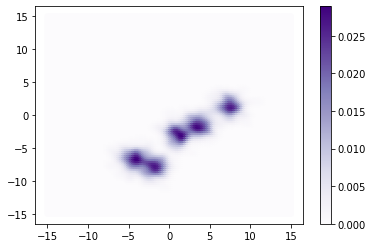

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1,1.0,30) # Test 30 bandwidths from 0.1 to 1.0 ####
K = 5 # 5-fold cross validation ####
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth'] ####
print(h_opt)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-15,15,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None") ####
plt.colorbar()

---

Now try a nearest neighbors approach to estimating the density. 

#### What value of $k$ do you need to make the plot look similar to the one above?

To make the plot below look similar to one above, k=90 works best. Smaller values of k create a sharper blobs (can tell the spikes) but the blobs are smaller and the max density is too high. Bigger values of k make bigger blobs but very blurry without the little spikes and the blobs start to come together (too big a k value won't resolve the individual blobs and has a lower max density)

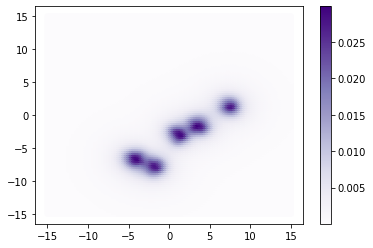

In [38]:
import matplotlib.pyplot as plt
from astroML.density_estimation import KNeighborsDensity

# Compute density with Bayesian nearest neighbors
k=90 ####
nbrs = KNeighborsDensity('bayesian',n_neighbors=k) ####
nbrs.fit(X) ####
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor="None")
plt.colorbar()

---

Now do a Gaussian mixture model.  Do a grid search for between 1 and 10 components.

In [6]:
#Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

6


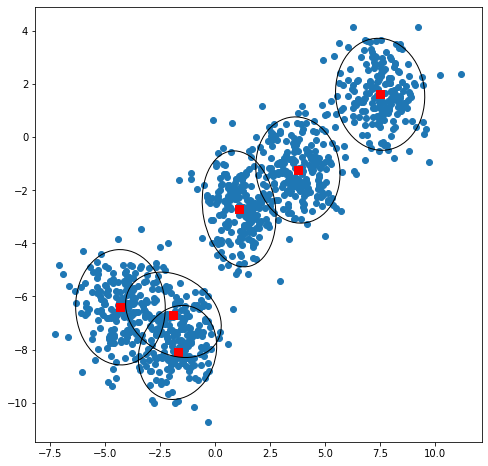

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

ncomps = np.arange(1,10,1) # Test 10 bandwidths from 1 to 10 ####
K = 5 # 5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': ncomps}, cv=K)  ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
ncomp_opt = grid.best_params_['n_components'] ####
print(ncomp_opt)

gmm = GaussianMixture(n_components=ncomp_opt) ####
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

#### Do you get the same answer (the same number of components) each time you run it?

No, I get either 5 or 6 components.

---

Now try Kmeans.  Here we will scale the data.

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) ####
kmeans.fit(X_scaled)
centers=kmeans.cluster_centers_ #location of the clusters ####
labels=kmeans.predict(X_scaled) #labels for each of the points ####
centers_unscaled = scaler.inverse_transform(centers) ####

Text(0.5, 1.0, 'Truth')

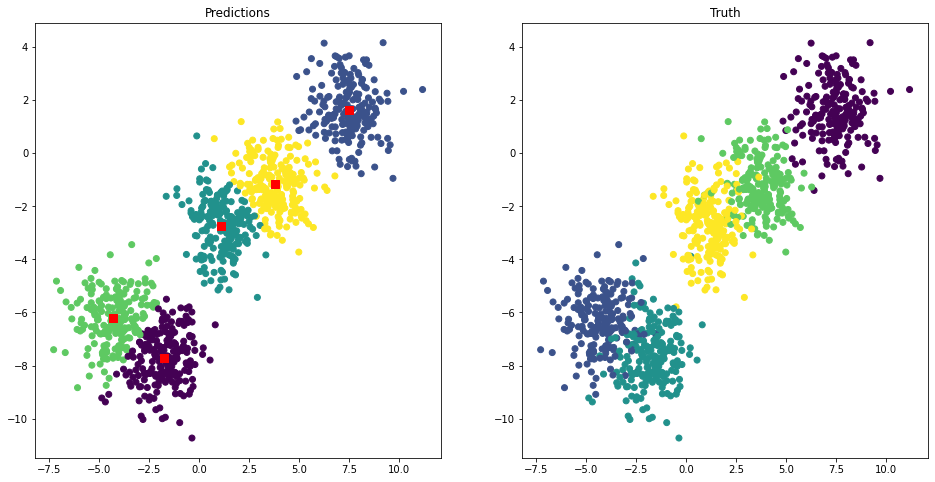

In [89]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].scatter(X[:,0],X[:,1],c=labels)
ax[0].scatter(centers_unscaled[:,0], centers_unscaled[:,1], marker='s', c='red', s=80)
ax[0].set_title("Predictions")

ax[1].scatter(X[:, 0], X[:, 1], c=y)
ax[1].set_title("Truth")

Let's evaluate how well we did in two other ways: a matrix and a score.

In [90]:
import pandas as pd

df = pd.DataFrame({'predictions': labels, 'truth': y})
ct = pd.crosstab(df['predictions'], df['truth'])
print(ct)

truth          0    1    2    3    4
predictions                         
0              0   16  185    0    1
1            194    0    0    1    0
2              0    0    1   11  185
3              0  184   14    0    0
4              6    0    0  188   14


In [91]:
from sklearn.metrics.cluster import homogeneity_score
score = homogeneity_score(df['truth'], df['predictions'])
print(score)

0.8473360929533544


#### What is the score for 3 clusters?

In [92]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) ####
kmeans.fit(X_scaled)
centers=kmeans.cluster_centers_ #location of the clusters ####
labels=kmeans.predict(X_scaled) #labels for each of the points ####
centers_unscaled = scaler.inverse_transform(centers) ####
df = pd.DataFrame({'predictions': labels, 'truth': y})
score = homogeneity_score(df['truth'], df['predictions'])
print(score)


0.6229568833968279


The score for 5 clusters was ~ 0.85 while the score for 3 clusters was 0.63. This matches expectations since lumping some of the 5 clusters together into 3 results in less homogeneity (versus having 5 distinct homogenous clusters

---

Finally, let's use DBSCAN.  Note that outliers are flagged as `labels_=-1`, so there is one more class that you might think.

Full credit if you can get a score of 0.6 or above.  Extra credit (0.1 of 5 points) for a score of 0.85 or above.


In [93]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

81


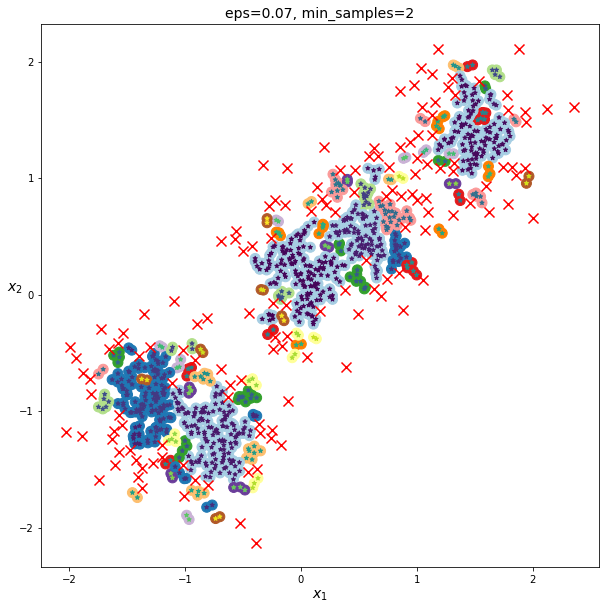

In [206]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.13, min_samples=5)
dbscan = DBSCAN(eps=0.13, min_samples=4)
dbscan = DBSCAN(eps=0.08, min_samples=4)
dbscan = DBSCAN(eps=0.0664, min_samples=2)

dbscan.fit(X_scaled)

plt.figure(figsize=(10, 10))
plot_dbscan(dbscan, X_scaled, size=100)
n_clusters=np.unique(dbscan.labels_)
print(len(n_clusters)) #Number of clusters found (+1)

In [207]:
import pandas as pd
df2 = pd.DataFrame({'predictions': dbscan.labels_, 'truth': y})
ct2 = pd.crosstab(df2['predictions'], df2['truth'])
print(ct2)

truth          0   1   2   3    4
predictions                      
-1            42  33  20  24   25
 0             0   0   1   0    5
 1             0   0   0   9  130
 2           104   0   0   0    0
 3             0   0   0   5    0
...          ...  ..  ..  ..  ...
 75            0   0   0   0    2
 76            0   2   0   0    0
 77            0   0   2   0    0
 78            0   0   0   0    2
 79            0   0   0   0    2

[81 rows x 5 columns]


In [208]:
from sklearn.metrics.cluster import homogeneity_score
score2 = homogeneity_score(df2['truth'], df2['predictions'])
print(score2)

0.7665506670991324


Optimized score2 is 0.767649019079514 for eps= 0.06648648648648649 min_samples= 2
81


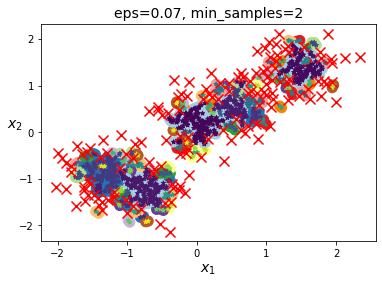

In [205]:
from sklearn.metrics.cluster import homogeneity_score
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

highest_score, highest_eps, highest_min = 0,0,0
for eps in np.linspace(0.01, 1, 1000):
    for min_sample in range(2,30,1):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(X_scaled)
        df2 = pd.DataFrame({'predictions': dbscan.labels_, 'truth': y})
        score2 = homogeneity_score(df2['truth'], df2['predictions'])
        # should be higher than 0.6 but since we want around 0.85, have 0.9 as max so as to not overfit
        if score2 > highest_score and score2 > 0.6 and score2 < 0.9:
#             print("score2=", score2, "higher than", highest_score)
#             n_clusters=np.unique(dbscan.labels_)
#             if len(n_clusters) <= 50:
#                 print("N_clusters is", len(n_clusters))
            highest_score = score2
            highest_eps, highest_min = eps, min_sample

dbscan = DBSCAN(eps=highest_eps, min_samples=highest_min)
dbscan.fit(X_scaled) 
df2 = pd.DataFrame({'predictions': dbscan.labels_, 'truth': y})
score2 = homogeneity_score(df2['truth'], df2['predictions'])
print("Highest score2 is", score2, "for eps=", highest_eps, "min_samples=", highest_min)
plot_dbscan(dbscan, X_scaled, size=100)
n_clusters=np.unique(dbscan.labels_)
print(len(n_clusters)) #Number of clusters found (+1)

#### Why do you think DBSCAN is having a hard time?  Think about what the Gaussian Mixture Model result showed.

DBScan is having a hard time because the Gaussian Mixture Model results show that either 5 or 6 components 
can characterize this data set. Because some of the clusters are close together and can be modeled (poorly) as a larger, inhomogenous cluster, DBScan is having a hard time trying to find homogenous clusters. Our score would be higher if each cluster was perfectly homogenous and could be easily separated out from the others. DBScan is better for distinct and homogenous clusters (like the two half moon example), plus many combinations of epsilon and min_samples does not help since depending what you choose, you will under or over fit the clusters that overlap (especially because DBScan tries to distinguish outliers). To get a high score with DBScan, there needs to be many many clusters because a lot of the data points could exist in one or more clusters (which is not what we want - we want a physically motivated model that makes sense). 

---
### Grade: 2.4/2.5 
- KDE:
- KNN:
- GMM:
- K-means: 
- DBSCAN: Need 5 clusters (-0.1)
- Extra: 